In [ ]:
!git clone https://github.com/saisriteja/audio_visual_work.git

Cloning into 'audio_visual_work'...
remote: Enumerating objects: 597, done.
remote: Counting objects: 100% (597/597), done.
remote: Compressing objects: 100% (597/597), done.
remote: Total 1453 (delta 0), reused 596 (delta 0), pack-reused 856
Receiving objects: 100% (1453/1453), 288.37 MiB | 28.96 MiB/s, done.
Checking out files: 100% (961/961), done.


In [ ]:
# %tensorflow_version 1.x

from keras.layers import Conv3D, MaxPool3D, Flatten, Dense, Conv2D, Activation, add, Reshape, Bidirectional
from keras.layers import Dropout, Input, BatchNormalization, Concatenate
from sklearn.metrics import confusion_matrix, accuracy_score
from plotly.offline import iplot, init_notebook_mode
from keras.losses import categorical_crossentropy
from keras.optimizers import Adadelta
import plotly.graph_objs as go
from matplotlib.pyplot import cm
from keras.models import Model
import numpy as np
import keras
import h5py
from keras.models import Sequential
from keras import optimizers
from keras.metrics import categorical_accuracy
from glob import glob
from keras.utils import to_categorical
import numpy as np
from keras.utils import np_utils
import os
import cv2
import pickle
from random import shuffle
init_notebook_mode(connected=True)

In [ ]:
def get_category(f):
    # print(f)
        
    if f[0] == 'a':
        return(0)
        
    elif f[0] == 'd':
        return(1)
        
    elif f[0] == 'n':
        return(2)
        
    elif f[0] == 'h':
        return(3)
    
    elif f[0] == 'f':
        return(4)
        
    elif f[0:2] == 'su':
        return(5)
        
    elif f[0:2] == 'sa':
        return(6)

def load_obj(name ):
    # print(name)
    with open(name , 'rb') as f:
        return pickle.load(f)

# files = glob('/content/audio_visual_work/data_video/DC*')

def get_train_test_val(person):
    f = {'a':[],
        'd':[],
        'sa':[],
        'su':[],
        'n':[],
        'h':[],
        'f':[]}

    # for i in list(f.keys()):
      #  print(glob(f'/content/audio_visual_work/data_video/DC_{i}*'))
      # f[i] = glob(f'/content/audio_visual_work/data_video/{person}_{i}*')
    for i in list(f.keys()):
        if i != 'n':
            f[i] = [f'/content/audio_visual_work/data_video/{person}_{i}{no+1}' for no in range(15)]
        if i == 'n':
            f[i] = [f'/content/audio_visual_work/data_video/{person}_{i}{no+1}' for no in range(30)]


    train = []
    test = []
    val = []


    for i in list(f.keys()):
      
      shuffle(f[i])

      # print('emotion',i,'elements',len(f[i]))

      # print(-0+int(0.7*(len(f[i]))) - int(0.7*(len(f[i])))+int(0.8*(len(f[i]))) -int(0.8*(len(f[i])))+int(1*(len(f[i]))))

      train.extend(f[i][0:int(0.7*(len(f[i])))])
      val.extend(f[i][int(0.7*(len(f[i]))):int(0.8*(len(f[i])))])
      test.extend(f[i][int(0.8*(len(f[i]))):])

      # print(len(train),len(test),len(val))

    return (sorted(set(train)),sorted(set(test)),sorted(set(val)))

In [ ]:
train,test,val = [],[],[]

for p in ['DC','KL','JE','JK']:
    a,b,c = get_train_test_val(p)
    train.extend(a)
    test.extend(b)
    val.extend(c)
    # break

In [ ]:
len(train)+len(test)+len(val)

480

In [ ]:

facial_path = '/content/audio_visual_work/data_video'
audio_path = '/content/audio_visual_work/data_audio'

def data_generator(files, batch_size = 8):
    while(True):
        batch_paths  = np.random.choice(a = files, size = batch_size)

        batch_facial  = []
        batch_audio = []
        batch_output = [] 

        for filename in batch_paths:

            # print(filename)

            cat = get_category(filename.split('_')[-1])

            batch_facial.append(load_obj(os.path.join(facial_path,filename)))


            b_f = np.array(batch_facial)/255.0
            # b_v = np.array(batch_audio)/255.0
            batch_output.append(cat)

        batch_output = np.array(batch_output)

        yield (b_f.astype('float32'),np_utils.to_categorical(batch_output,num_classes=7))



In [ ]:
train_generator = data_generator(train,batch_size=8)
val_generator = data_generator(val,batch_size=8)
x,y = next(train_generator)
x.shape

(8, 96, 64, 64, 3)

In [ ]:

def get_model():

    ## input layer
    input_layer = Input((96, 64,64, 3))

    ## convolutional layers
    conv_layer1 = Conv3D(filters=32, kernel_size=(15, 3, 3), activation='relu')(input_layer)
    pooling_layer2 = MaxPool3D(pool_size=(3,3,3))(conv_layer1)
    dropout = Dropout(0.4)(pooling_layer2)
    flatten_layer = Flatten()(dropout)


    dense_layer1 = Dense(units=128, activation='relu')(flatten_layer)
    dense_layer1 = Dropout(0.4)(dense_layer1)

    output_layer = Dense(units=7, activation='softmax')(dense_layer1)
    model = Model(inputs=input_layer, outputs=output_layer)
    return model

model = get_model()


In [ ]:
my_callbacks = [
    keras.callbacks.EarlyStopping(patience=30, monitor="val_loss",min_delta=0.0001,verbose = 1),
    keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5',verbose = 1,save_best_only=True),
    # keras.callbacks.TensorBoard(log_dir='./logs'),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss",factor=0.5,patience=20,cooldown = 1,verbose = 1)
]
model = get_model()
model.compile(loss='categorical_crossentropy',optimizer=optimizers.SGD(lr=1e-4,momentum = 0.9),metrics=['acc'])


batch_size = 8
history = model.fit_generator(train_generator,
                              steps_per_epoch=int(len(train)/batch_size),
                              epochs=300,
                              validation_data= val_generator,
                              validation_steps=len(val)//batch_size,
                              callbacks = my_callbacks)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/300
40/40 [==============================] - ETA: 0s - loss: 1.9197 - acc: 0.2781
Epoch 00001: val_loss improved from inf to 1.86912, saving model to model.01-1.87.h5
40/40 [==============================] - 7s 178ms/step - loss: 1.9197 - acc: 0.2781 - val_loss: 1.8691 - val_acc: 0.2679
Epoch 2/300
40/40 [==============================] - ETA: 0s - loss: 1.8663 - acc: 0.2875
Epoch 00002: val_loss did not improve from 1.86912
40/40 [==============================] - 6s 160ms/step - loss: 1.8663 - acc: 0.2875 - val_loss: 1.9728 - val_acc: 0.1607
Epoch 3/300
40/40 [==============================] - ETA: 0s - loss: 1.8363 - acc: 0.3187
Epoch 00003: val_loss did not improve from 1.86912
40/40 [==============================] - 6s 161ms/step - loss: 1.8363 - acc: 0.3187 - val_loss: 1.8707 - val_acc: 0.1607
Epoch 4/300
40/40 [==============================] - ETA: 0s - loss: 1.8109 - acc: 0.3375
Epoch 00004: v

In [ ]:
model = get_model()
model.load_weights('/content/model.131-0.08.h5')

In [ ]:
def load_obj(name ):
    # print(name)
    with open(name , 'rb') as f:
        return pickle.load(f)

def data_generator(files, batch_size = 8):
    while(True):
        # batch_paths  = np.random.choice(a = files, size = batch_size)
        batch_paths = files

        batch_facial  = []
        batch_audio = []
        batch_output = [] 

        for filename in batch_paths:

            # print(filename)

            cat = get_category(filename.split('_')[-1])

            batch_facial.append(load_obj(os.path.join(facial_path,filename)))


            b_f = np.array(batch_facial)/255.0
            # b_v = np.array(batch_audio)/255.0
            batch_output.append(cat)

        batch_output = np.array(batch_output)

        yield (b_f.astype('float32'),np_utils.to_categorical(batch_output,num_classes=7))


test_inp,test_out = next(data_generator(test))

# model.predict()

In [ ]:
test_inp.shape

(96, 96, 64, 64, 3)

In [ ]:
predicted = model.predict(test_inp)

In [ ]:
predicted.shape

(96, 7)

In [ ]:
y_pred = [np.argmax(i) for i in predicted]

In [ ]:
y_true = [np.argmax(i) for i in test_out]

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true, y_pred)

array([[10,  1,  1,  0,  0,  0,  0],
       [ 1, 11,  0,  0,  0,  0,  0],
       [ 0,  0, 24,  0,  0,  0,  0],
       [ 0,  0,  0, 12,  0,  0,  0],
       [ 0,  0,  0,  0, 12,  0,  0],
       [ 0,  0,  0,  1,  0, 11,  0],
       [ 0,  0,  0,  0,  0,  0, 12]])

In [ ]:
(confusion_matrix(y_true, y_pred,normalize='true')*100).astype('int')

array([[ 83,   8,   8,   0,   0,   0,   0],
       [  8,  91,   0,   0,   0,   0,   0],
       [  0,   0, 100,   0,   0,   0,   0],
       [  0,   0,   0, 100,   0,   0,   0],
       [  0,   0,   0,   0, 100,   0,   0],
       [  0,   0,   0,   8,   0,  91,   0],
       [  0,   0,   0,   0,   0,   0, 100]])

In [ ]:
target_names = 'a d n h f su sa'.split(' ')

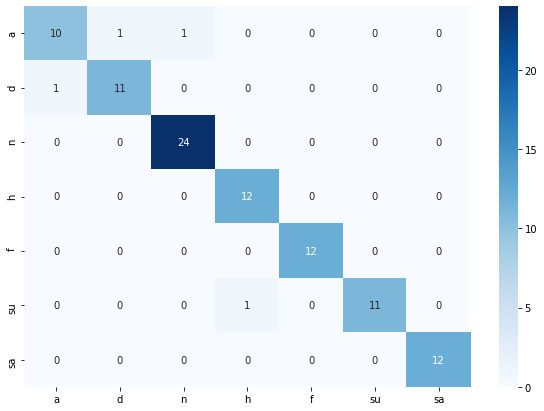

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(confusion_matrix(y_true, y_pred), index = [i for i in target_names],
                  columns = [i for i in target_names])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,cmap='Blues')

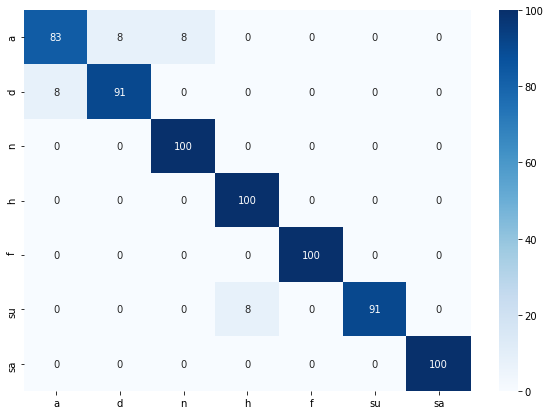

In [ ]:
df_cm = pd.DataFrame((confusion_matrix(y_true, y_pred,normalize='true')*100).astype('int')
, index = [i for i in target_names],
                  columns = [i for i in target_names])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='g',cmap= 'Blues')

In [ ]:
from sklearn.metrics import classification_report


print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

           a       0.91      0.83      0.87        12
           d       0.92      0.92      0.92        12
           n       0.96      1.00      0.98        24
           h       0.92      1.00      0.96        12
           f       1.00      1.00      1.00        12
          su       1.00      0.92      0.96        12
          sa       1.00      1.00      1.00        12

    accuracy                           0.96        96
   macro avg       0.96      0.95      0.95        96
weighted avg       0.96      0.96      0.96        96



In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_true, y_pred)

0.9583333333333334

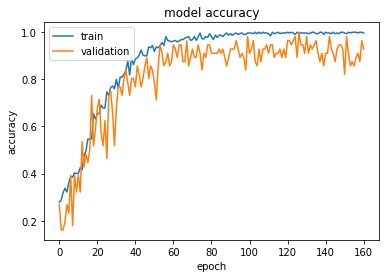

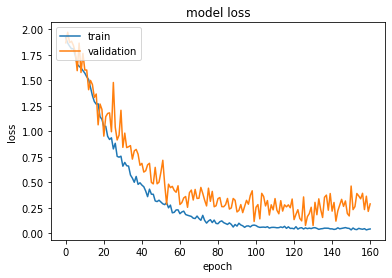

In [ ]:
import matplotlib.pyplot as plt


plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
import pickle
filename = 'filenames.pkl'
outfile = open(filename,'wb')

pickle.dump([train,test,val],outfile)
outfile.close()